In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D

In [3]:
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, symmetric_sne=False):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):
        if symmetric_sne:
            # Compute pairwise affinities
            sum_Y = np.sum(np.square(Y), 1)
            Q = -2. * np.dot(Y, Y.T)
            Q = np.add(np.add(Q, sum_Y).T, sum_Y)
            Q = np.exp(-Q)
            Q[range(n), range(n)] = 0
            Q = Q / np.sum(Q)
            Q = np.maximum(Q, 1e-12)

            # Compute gradient
            PQ = P - Q
            for i in range(n):
                dY[i, :] = 2. * np.sum(np.tile(PQ[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)
        else:
            # Compute pairwise affinities
            sum_Y = np.sum(np.square(Y), 1)
            num = -2. * np.dot(Y, Y.T)
            num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
            num[range(n), range(n)] = 0.
            Q = num / np.sum(num)
            Q = np.maximum(Q, 1e-12)

            # Compute gradient
            PQ = P - Q
            for i in range(n):
                dY[i, :] = 4. * np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
    return Y, P, Q

In [4]:
X = np.loadtxt("data/mnist2500_X.txt")
labels = np.loadtxt("data/mnist2500_labels.txt")

In [52]:
Y, P, Q = tsne(X, 2, 30)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.402726
Iteration 10: error is 20.948175
Iteration 20: error is 18.135848
Iteration 30: error is 16.310245
Iteration 40: error is 15.564107
Iteration 50: error is 15.361919
Iteration 60: error is 15.308502
Iteration 70: error is 15.278739
Iteration 80: error is 15.266234
Iteration 90: error is 15.248381
Iteration 100: error is 15.237610
Iteration 110: error is 2.111928
Iteration 120: error is 1.720408
Iteration 130: error is 1.482163
Iteration 140: error is 1.348100
Iteration 150: error is 1.268486
Iteration 160: error is 1.216310
Iteration 170: error is 1.178153
Iteration 180: error is 1.149181
Iteration 190: error is 1.126473
Iteration 200: error is 1.108011
Iteration 210: error

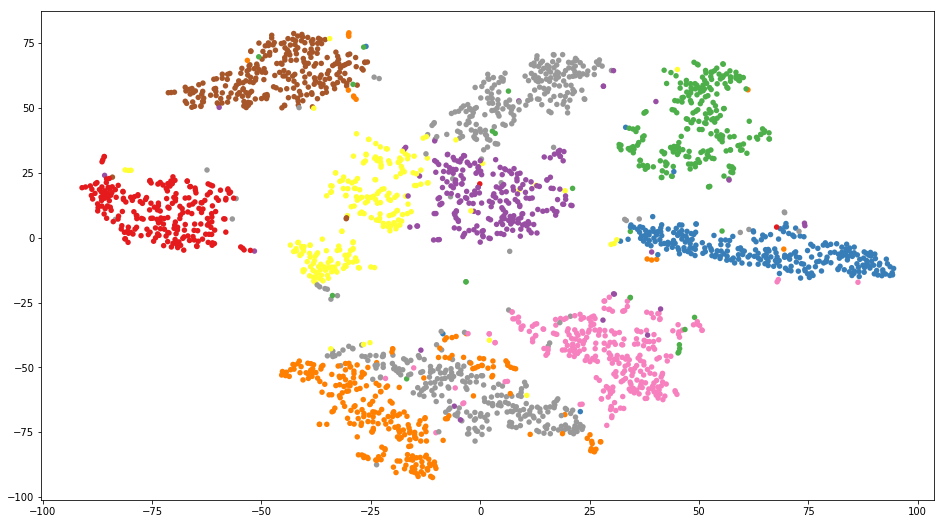

In [55]:
# color_list = ["orangered", "orange", "gold", "lime", "green", "deepskyblue", "blue", "mediumblue", "purple", "m"]

plt.figure(figsize=(16, 9))
plt.scatter(Y[:, 0], Y[:, 1], 30, labels, marker='o', linewidths=0.0, cmap="Set1")
plt.show()

In [56]:
P_ = np.trim_zeros(np.sort(P.flatten()))
for i in range(len(P_)):
    if P_[i] <= 1e-12:
        P_[i] = 0
P_ = np.trim_zeros(P_)

Q_ = np.trim_zeros(np.sort(Q.flatten()))
for i in range(len(Q_)):
    if Q_[i] <= 1e-12:
        Q_[i] = 0
Q_ = np.trim_zeros(Q_)

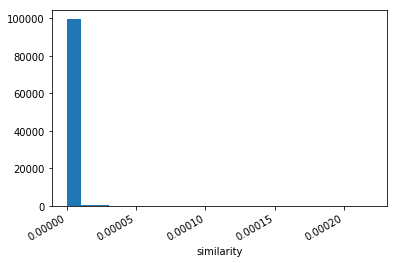

In [57]:
binwidth = 1e-5
bins = np.arange(min(P_), max(P_) + binwidth, binwidth)
fig = plt.figure()
plt.hist(P_, bins=bins, normed=1)
plt.xlabel('similarity')
fig.autofmt_xdate()
plt.show()

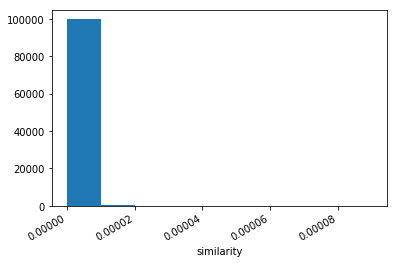

In [58]:
binwidth = 1e-5
bins = np.arange(min(Q_), max(Q_) + binwidth, binwidth)
fig = plt.figure()
plt.hist(Q_, bins=bins, normed=1)
plt.xlabel('similarity')
fig.autofmt_xdate()
plt.show()

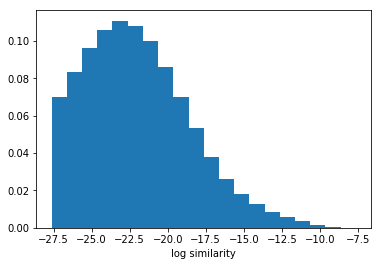

In [59]:
binwidth = 1
bins = np.arange(min(np.log(P_)), max(np.log(P_)) + binwidth, binwidth)
plt.figure()
plt.hist(np.log(P_), bins=bins, normed=1)
plt.xlabel('log similarity')
plt.show()

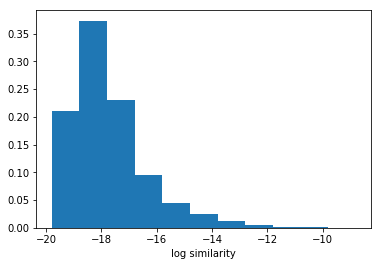

In [60]:
binwidth = 1
bins = np.arange(min(np.log(Q_)), max(np.log(Q_)) + binwidth, binwidth)
plt.figure()
plt.hist(np.log(Q_), bins=bins, normed=1)
plt.xlabel('log similarity')
plt.show()

In [61]:
Y2, P2, Q2 = tsne(X, 2, 50, 5, True)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.760057
Iteration 10: error is 28.459697
Iteration 20: error is 22.800212
Iteration 30: error is 20.214656
Iteration 40: error is 19.609151
Iteration 50: error is 19.050886
Iteration 60: error is 18.836691
Iteration 70: error is 18.806671
Iteration 80: error is 18.760529
Iteration 90: error is 18.736408
Iteration 100: error is 18.708559
Iteration 110: error is 2.794075
Iteration 120: error is 2.448725
Iteration 130: error is 2.421889
Iteration 140: error is 2.432407
Iteration 150: error is 2.449893
Iteration 160: error is 2.454371
Iteration 170: error is 2.451165
Iteration 180: error is 2.444173
Iteration 190: error is 2.442134
Iteration 200: error is 2.439965
Iteration 210: error

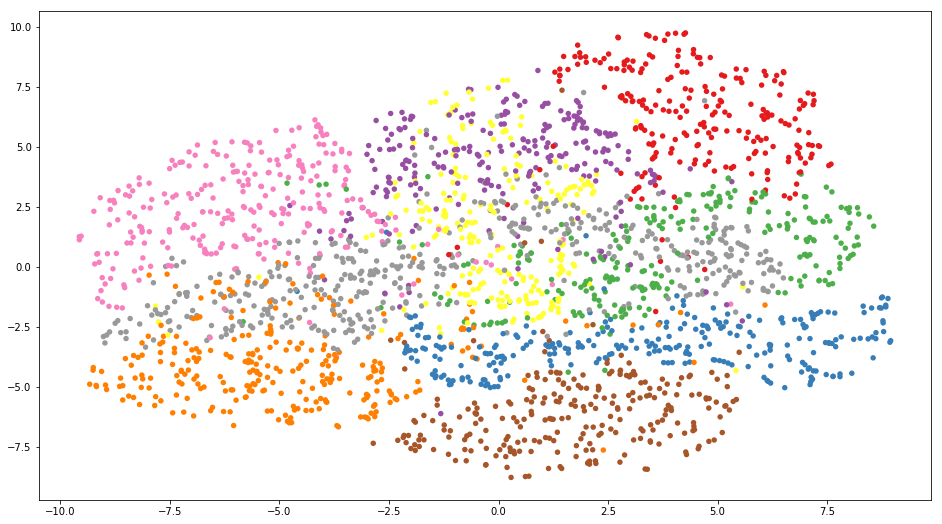

In [68]:
plt.figure(figsize=(16, 9))
plt.scatter(Y2[:, 0], Y2[:, 1], 30, labels, marker='o', linewidths=0.0, cmap="Set1")
plt.show()

In [62]:
P2_ = np.trim_zeros(np.sort(P2.flatten()))
for i in range(len(P2_)):
    if P2_[i] <= 1e-12:
        P2_[i] = 0
P2_ = np.trim_zeros(P2_)

Q2_ = np.trim_zeros(np.sort(Q2.flatten()))
for i in range(len(Q2_)):
    if Q2_[i] <= 1e-12:
        Q2_[i] = 0
Q2_ = np.trim_zeros(Q2_)

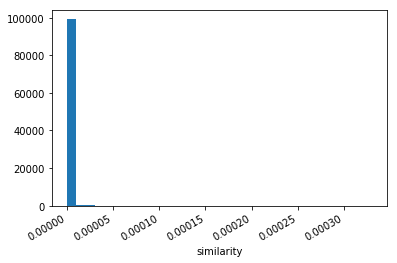

In [64]:
binwidth = 1e-5
bins = np.arange(min(P2_), max(P2_) + binwidth, binwidth)
fig = plt.figure()
plt.hist(P2_, bins=bins, normed=1)
plt.xlabel('similarity')
fig.autofmt_xdate()
plt.show()

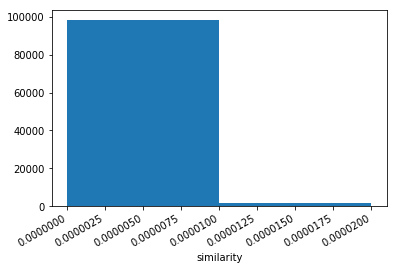

In [65]:
binwidth = 1e-5
bins = np.arange(min(Q2_), max(Q2_) + binwidth, binwidth)
fig = plt.figure()
plt.hist(Q2_, bins=bins, normed=1)
plt.xlabel('similarity')
fig.autofmt_xdate()
plt.show()

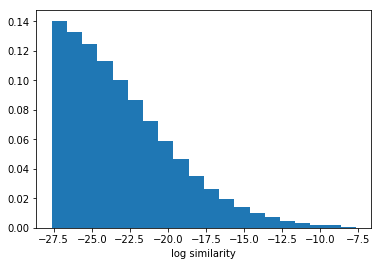

In [66]:
binwidth = 1
bins = np.arange(min(np.log(P2_)), max(np.log(P2_)) + binwidth, binwidth)
plt.figure()
plt.hist(np.log(P2_), bins=bins, normed=1)
plt.xlabel('log similarity')
plt.show()

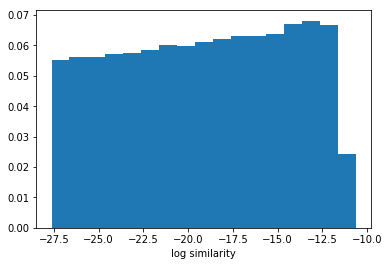

In [67]:
binwidth = 1
bins = np.arange(min(np.log(Q2_)), max(np.log(Q2_)) + binwidth, binwidth)
plt.figure()
plt.hist(np.log(Q2_), bins=bins, normed=1)
plt.xlabel('log similarity')
plt.show()